In [1]:
import pickle
import tensorflow
from keras import Model
from keras.layers import (
    Input,
    TimeDistributed,
    LSTM,
    Dense,
    Input,
    Dense,
    Conv1D,
    Flatten, 
    Embedding,
    Dropout, 
    Bidirectional)
from imblearn.over_sampling import SMOTE
import numpy
from numba import cuda 
import tensorflow as tf
import tensorflow_models as tfm
import matplotlib.pyplot as plt
device = cuda.get_current_device()
device.reset()
%run constants.py


/home/aaron/anaconda3/envs/tf/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_directories(timestep:int, output: int):

    f = os.path.basename(X_TRAIN_INPUT_SAVE_FILE_VEC_MULTI_TIMESTEP)
    X_TRAIN_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(X_TEST_INPUT_SAVE_FILE_VEC_MULTI_TIMESTEP)
    X_TEST_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(X_VAL_INPUT_SAVE_FILE_VEC_MULTI_TIMESTEP)
    X_VAL_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(timestep) + os.path.splitext(os.path.basename(f))[1]) 

    f = os.path.basename(Y_TRAIN_INPUT_SAVE_FILE)
    Y_TRAIN_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(output) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(Y_TEST_INPUT_SAVE_FILE)
    Y_TEST_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(output) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(Y_VAL_INPUT_SAVE_FILE)
    Y_VAL_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(output) + os.path.splitext(os.path.basename(f))[1]) 

    f = os.path.basename(EMBEDDING_MATRIX_SAVE_FILE)
    EMBEDDING_MATRIX_DIR= os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(TIME_STEP) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(VOCAB_SAVE_FILE)
    VOCAB_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(TIME_STEP) + os.path.splitext(os.path.basename(f))[1]) 
    f = os.path.basename(TRAIN_CORPORA)
    TRAIN_CORPORA_DIR = os.path.join(DATA_DIR, os.path.splitext(os.path.basename(f))[0] + "_" + str(TIME_STEP) + os.path.splitext(os.path.basename(f))[1]) 

    file_suffix: str = f'_i{TIME_STEP}_o{output}'
    return X_TRAIN_DIR, X_VAL_DIR, X_TEST_DIR, Y_TRAIN_DIR, Y_VAL_DIR, Y_TEST_DIR, EMBEDDING_MATRIX_DIR, VOCAB_DIR, TRAIN_CORPORA_DIR


In [3]:
def load_variables(X_TRAIN_DIR, Y_TRAIN_DIR, X_VAL_DIR, Y_VAL_DIR, X_TEST_DIR, Y_TEST_DIR, EMBEDDING_DIR): 
        with open(X_TRAIN_DIR, "rb") as f:
                x_train = pickle.load(f)

        with open(Y_TRAIN_DIR, "rb") as f:
                y_train = pickle.load(f)

        with open(X_VAL_DIR, "rb") as f:
                x_val = pickle.load(f)

        with open(Y_VAL_DIR, "rb") as f:
                y_val = pickle.load(f)

        with open(X_TEST_DIR, "rb") as f:
                x_test = pickle.load(f)

        with open(Y_TEST_DIR, "rb") as f:
                y_test = pickle.load(f)

        with open(EMBEDDING_DIR, "rb") as f:
                embedding_matrix = pickle.load(f)
                
        embedding_layer = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, weights = [embedding_matrix], trainable=False)
        return x_train, y_train, x_val, y_val, x_test, y_test, embedding_matrix, embedding_layer

In [4]:
def balance_training_dataset(x_train, y_train): 
    if BALANCE_DATA:
        arr = x_train.reshape(len(x_train), -1)
        sm = SMOTE(random_state=SEED)
        x_train_bal, y_train = sm.fit_resample(arr, y_train.ravel())
        print(f"After OverSampling, the shape of train_X: {x_train_bal.shape}")
        print(f"After OverSampling, the shape of train_y: {y_train.shape}")
        print(f"After OverSampling, counts of label '1': {sum(y_train == 1)}")
        print(f"After OverSampling, counts of label '0': {sum(y_train == 0)}")
        x_train = numpy.reshape(x_train_bal, (-1, x_train.shape[1], x_train.shape[2]))
    return x_train, y_train


# LSTM Classifier

In [5]:
def lstm_model(embedding_layer, timestep, file_suffix):
    document_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
    embedding_sequences =embedding_layer(document_input)
    x = LSTM(timestep)(embedding_sequences)
    x = Dropout(0.3)(x)
    doc_model = Model(document_input, x)
    input_docs = Input(
                shape=(timestep, MAX_SEQUENCE_LENGTH), name="input_docs", dtype="int32"
            )

    x = TimeDistributed(doc_model, name="token_embedding_model")(input_docs)
    x = LSTM(timestep)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(input_docs, outputs, name = f'lstm{file_suffix}')
    return model

# Stacked LSTM Classifier

In [6]:
def stacked_lstm_model(embedding_layer, timestep, file_suffix):
    document_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int64")
    embedding_sequences =embedding_layer(document_input)
    x = LSTM(timestep, return_sequences=True)(embedding_sequences)
    x = LSTM(timestep)(x)
    x = Dropout(0.3)(x)
    doc_model = Model(document_input, x)
    input_docs = Input(
                shape=(timestep, MAX_SEQUENCE_LENGTH), name="input_docs", dtype="int32"
            )

    x = TimeDistributed(doc_model, name="token_embedding_model")(input_docs)
    x = LSTM(timestep)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(input_docs, outputs, name = f'stacked_lstm{file_suffix}')

    model.summary()
    return model

# BiLSTM Classifier

In [7]:
def bilstm_model(embedding_layer, timestep, file_suffix):
    document_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
    embedding_sequences =embedding_layer(document_input)
    x = Bidirectional(LSTM(timestep))(embedding_sequences)
    x = Dropout(0.3)(x)
    doc_model = Model(document_input, x)
    input_docs = Input(
                shape=(timestep, MAX_SEQUENCE_LENGTH), name="input_docs", dtype="int32"
            )

    x = TimeDistributed(doc_model, name="token_embedding_model")(input_docs)
    x = Bidirectional(LSTM(timestep))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(input_docs, outputs, name = f'bilstm{file_suffix}')
    model.summary()
    return model

# Stacked BiLSTM Classifier

In [8]:
def bilstm_stacked_model(embedding_layer, timestep, file_suffix):
    if timestep == 90: # Override d/t hardware constraints. 
        timestep == 60
    document_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
    embedding_sequences =embedding_layer(document_input)
    x = Bidirectional(LSTM(timestep, return_sequences=True))(embedding_sequences)
    x = Bidirectional(LSTM(timestep))(x)
    x = Dropout(0.3)(x)
    doc_model = Model(document_input, x)
    input_docs = Input(
                shape=(timestep, MAX_SEQUENCE_LENGTH), name="input_docs", dtype="int32"
            )

    x = TimeDistributed(doc_model, name="token_embedding_model")(input_docs)
    x = Bidirectional(LSTM(timestep))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = Model(input_docs, outputs, name = f'bilstm_stacked{file_suffix}')
    model.summary()
    return model

# CNN Classifier

In [9]:
def cnn_model(embedding_layer, timestep, file_suffix):
    document_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
    embedding_sequences = embedding_layer(document_input)

    x = Conv1D(filters=400, kernel_size=5, padding="valid")(embedding_sequences)
    x = Dropout(0.3)(x)
    doc_model = Model(document_input, x)

    input_docs = Input(
            shape=(timestep, MAX_SEQUENCE_LENGTH), name="input_docs", dtype="int32"
        )

    x = TimeDistributed(doc_model, name="token_embedding_model")(input_docs)
    x = Conv1D(filters=400, kernel_size=5, padding="valid")(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    outputs = Dense(1, activation="sigmoid")(x)

    model = Model(input_docs, outputs, name = f'cnn{file_suffix}')
    return model

In [10]:

def plot_graph(history):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    return plt

In [11]:

def run_model(model_type: str, x_train, y_train, x_val, y_val, x_test, y_test, embedding_layer, file_suffix, timestep):

    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = tf.metrics.BinaryAccuracy()
    
    if model_type == 'lstm':
        model = lstm_model(embedding_layer = embedding_layer, file_suffix=file_suffix, timestep = timestep)

    if model_type == 'cnn':
        model = cnn_model(embedding_layer = embedding_layer, file_suffix=file_suffix, timestep = timestep)

    if model_type == 'stacked_lstm':
        model = stacked_lstm_model(embedding_layer = embedding_layer, file_suffix=file_suffix, timestep = timestep)

    
    if model_type == 'bilstm':
        model = bilstm_model(embedding_layer = embedding_layer, file_suffix=file_suffix, timestep = timestep)
    
    if model_type == 'stacked_bilstm':
        model = bilstm_stacked_model(embedding_layer = embedding_layer, file_suffix=file_suffix, timestep = timestep)



    model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)
    history = model.fit(x=x_train, y=y_train,
                                    validation_data = (x_val, y_val),
                                epochs=NUM_EPOCHS, verbose=1 if NUM_EPOCHS % 10 == 0 else 0)
    model_save_dir = f"saved_model/{model_type}{file_suffix}"
    model.save(model_save_dir)

    loss, accuracy = model.evaluate(x= x_test, y= y_test)
    graph = plot_graph(history)
    save_file_name: str = f'saved_graphs/{model_type}{file_suffix}.png' 
    graph.savefig(save_file_name)
    return accuracy, loss



After OverSampling, the shape of train_X: (2628, 18000)
After OverSampling, the shape of train_y: (2628,)
After OverSampling, counts of label '1': 1314
After OverSampling, counts of label '0': 1314


2022-08-15 21:35:13.621120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-15 21:35:14.505182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6672 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:03:00.0, compute capability: 7.5
2022-08-15 21:35:14.506030: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6671 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:04:00.0, compute capability: 7.5


Epoch 1/30


2022-08-15 21:35:16.073071: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-08-15 21:35:16.772834: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.0.145, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-08-15 21:35:18.672197: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 880.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-15 21:35:18.672262: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 880.38MiB with freed_by_count=0. The caller indicates that this is not a failure, but 

83/83 [==============================] - 64s 705ms/step - loss: 0.6736 - binary_accuracy: 0.5734 - val_loss: 0.6798 - val_binary_accuracy: 0.5803
Epoch 2/30
83/83 [==============================] - 59s 712ms/step - loss: 0.5654 - binary_accuracy: 0.7237 - val_loss: 0.6862 - val_binary_accuracy: 0.5876
Epoch 3/30
83/83 [==============================] - 62s 747ms/step - loss: 0.5088 - binary_accuracy: 0.7801 - val_loss: 0.6953 - val_binary_accuracy: 0.5766
Epoch 4/30
83/83 [==============================] - 63s 756ms/step - loss: 0.4663 - binary_accuracy: 0.8048 - val_loss: 0.7095 - val_binary_accuracy: 0.5730
Epoch 5/30
83/83 [==============================] - 62s 752ms/step - loss: 0.4295 - binary_accuracy: 0.8291 - val_loss: 0.7246 - val_binary_accuracy: 0.5693
Epoch 6/30
83/83 [==============================] - 62s 744ms/step - loss: 0.4006 - binary_accuracy: 0.8520 - val_loss: 0.7348 - val_binary_accuracy: 0.5803
Epoch 7/30
83/83 [==============================] - 61s 739ms/step - 

INFO:tensorflow:Assets written to: saved_model/cnn_i90_o60/assets


INFO:tensorflow:Assets written to: saved_model/cnn_i90_o60/assets


22/22 [==============================] - 4s 184ms/step - loss: 1.0217 - binary_accuracy: 0.5679
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for cnn with 90 timesteps and 60 outputs
Loss: 1.0216602087020874
Accuracy: 0.5678831934928894
Epoch 1/30
83/83 [==============================] - 11s 97ms/step - loss: 0.6939 - binary_accuracy: 0.4734 - val_loss: 0.6932 - val_binary_accuracy: 0.5474
Epoch 2/30
83/83 [==============================] - 7s 86ms/step - loss: 0.6935 - binary_accuracy: 0.5221 - val_loss: 0.6930 - val_binary_accuracy: 0.5584
Epoch 3/30
83/83 [==============================] - 7s 87ms/step - loss: 0.6926 - binary_accuracy: 0.5342 - val_loss: 0.6927 - val_binary_accuracy: 0.5730
Epoch 4/30
83/83 [==============================] - 7s 87ms/step - loss: 0.6920 - binary_accuracy: 0.5468 - val_loss: 0.6925 - val_binary_accuracy: 0.5839
Epoch 5/30
83/83 [==============================] - 7s 88ms/step - loss: 0.6912 - binary_accuracy: 0.55

INFO:tensorflow:Assets written to: saved_model/lstm_i90_o60/assets


INFO:tensorflow:Assets written to: saved_model/lstm_i90_o60/assets


22/22 [==============================] - 1s 34ms/step - loss: 0.6701 - binary_accuracy: 0.6000
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for lstm with 90 timesteps and 60 outputs
Loss: 0.6700835227966309
Accuracy: 0.6000000238418579
Model: "stacked_lstm_i90_o60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_docs (InputLayer)     [(None, 90, 200)]         0         
                                                                 
 token_embedding_model (Time  (None, 90, 90)           1133920   
 Distributed)                                                    
                                                                 
 lstm_4 (LSTM)               (None, 90)                65160     
                                                                 
 dropout_5 (Dropout)         (None, 90)                0         
                                  

INFO:tensorflow:Assets written to: saved_model/stacked_lstm_i90_o60/assets


INFO:tensorflow:Assets written to: saved_model/stacked_lstm_i90_o60/assets


22/22 [==============================] - 1s 61ms/step - loss: 0.6701 - binary_accuracy: 0.5971
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for stacked_lstm with 90 timesteps and 60 outputs
Loss: 0.670103132724762
Accuracy: 0.5970802903175354
Model: "bilstm_i90_o60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_docs (InputLayer)     [(None, 90, 200)]         0         
                                                                 
 token_embedding_model (Time  (None, 90, 180)          1137520   
 Distributed)                                                    
                                                                 
 bidirectional_1 (Bidirectio  (None, 180)              195120    
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (Non

INFO:tensorflow:Assets written to: saved_model/bilstm_i90_o60/assets


INFO:tensorflow:Assets written to: saved_model/bilstm_i90_o60/assets


22/22 [==============================] - 1s 62ms/step - loss: 0.6427 - binary_accuracy: 0.6321
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for bilstm with 90 timesteps and 60 outputs
Loss: 0.642741858959198
Accuracy: 0.6321167945861816
After OverSampling, the shape of train_X: (2888, 18000)
After OverSampling, the shape of train_y: (2888,)
After OverSampling, counts of label '1': 1444
After OverSampling, counts of label '0': 1444
Epoch 1/30
91/91 [==============================] - 69s 748ms/step - loss: 0.6591 - binary_accuracy: 0.6160 - val_loss: 0.7006 - val_binary_accuracy: 0.5547
Epoch 2/30
91/91 [==============================] - 70s 769ms/step - loss: 0.5526 - binary_accuracy: 0.7334 - val_loss: 0.7336 - val_binary_accuracy: 0.5511
Epoch 3/30
91/91 [==============================] - 69s 757ms/step - loss: 0.4931 - binary_accuracy: 0.7829 - val_loss: 0.7563 - val_binary_accuracy: 0.5657
Epoch 4/30
91/91 [==============================] - 68

INFO:tensorflow:Assets written to: saved_model/cnn_i90_o90/assets


INFO:tensorflow:Assets written to: saved_model/cnn_i90_o90/assets


22/22 [==============================] - 3s 151ms/step - loss: 1.0804 - binary_accuracy: 0.6044
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for cnn with 90 timesteps and 90 outputs
Loss: 1.0804216861724854
Accuracy: 0.6043795347213745
Epoch 1/30
91/91 [==============================] - 11s 95ms/step - loss: 0.6938 - binary_accuracy: 0.4952 - val_loss: 0.6934 - val_binary_accuracy: 0.5109
Epoch 2/30
91/91 [==============================] - 8s 86ms/step - loss: 0.6934 - binary_accuracy: 0.5256 - val_loss: 0.6932 - val_binary_accuracy: 0.4891
Epoch 3/30
91/91 [==============================] - 8s 87ms/step - loss: 0.6926 - binary_accuracy: 0.5461 - val_loss: 0.6930 - val_binary_accuracy: 0.4927
Epoch 4/30
91/91 [==============================] - 8s 87ms/step - loss: 0.6917 - binary_accuracy: 0.5492 - val_loss: 0.6927 - val_binary_accuracy: 0.5073
Epoch 5/30
91/91 [==============================] - 8s 88ms/step - loss: 0.6914 - binary_accuracy: 0.56

INFO:tensorflow:Assets written to: saved_model/lstm_i90_o90/assets


INFO:tensorflow:Assets written to: saved_model/lstm_i90_o90/assets


22/22 [==============================] - 1s 34ms/step - loss: 0.6624 - binary_accuracy: 0.5883
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for lstm with 90 timesteps and 90 outputs
Loss: 0.6624262928962708
Accuracy: 0.5883211493492126
Model: "stacked_lstm_i90_o90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_docs (InputLayer)     [(None, 90, 200)]         0         
                                                                 
 token_embedding_model (Time  (None, 90, 90)           1133920   
 Distributed)                                                    
                                                                 
 lstm_11 (LSTM)              (None, 90)                65160     
                                                                 
 dropout_13 (Dropout)        (None, 90)                0         
                                  

INFO:tensorflow:Assets written to: saved_model/stacked_lstm_i90_o90/assets


INFO:tensorflow:Assets written to: saved_model/stacked_lstm_i90_o90/assets


22/22 [==============================] - 1s 61ms/step - loss: 0.6737 - binary_accuracy: 0.5591
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for stacked_lstm with 90 timesteps and 90 outputs
Loss: 0.6737403869628906
Accuracy: 0.5591241121292114
Model: "bilstm_i90_o90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_docs (InputLayer)     [(None, 90, 200)]         0         
                                                                 
 token_embedding_model (Time  (None, 90, 180)          1137520   
 Distributed)                                                    
                                                                 
 bidirectional_3 (Bidirectio  (None, 180)              195120    
 nal)                                                            
                                                                 
 dropout_15 (Dropout)        (No

INFO:tensorflow:Assets written to: saved_model/bilstm_i90_o90/assets


INFO:tensorflow:Assets written to: saved_model/bilstm_i90_o90/assets


22/22 [==============================] - 1s 63ms/step - loss: 0.6535 - binary_accuracy: 0.5985
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])
Evaluation for bilstm with 90 timesteps and 90 outputs
Loss: 0.6534835696220398
Accuracy: 0.5985401272773743


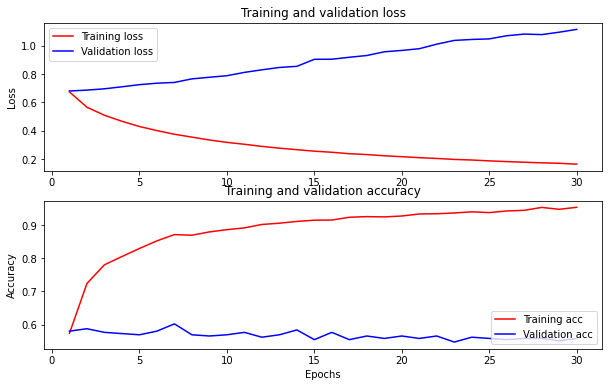

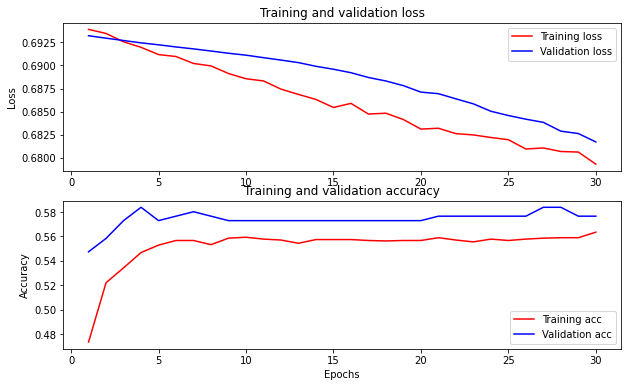

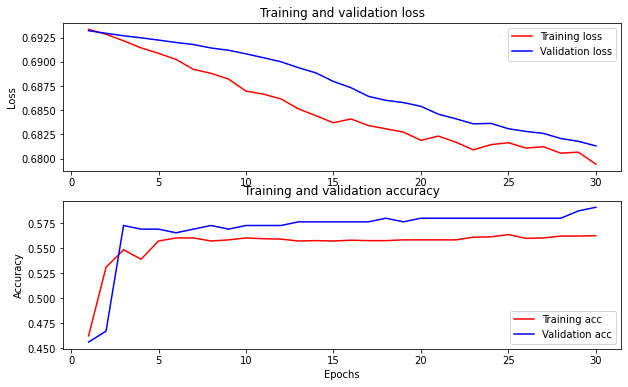

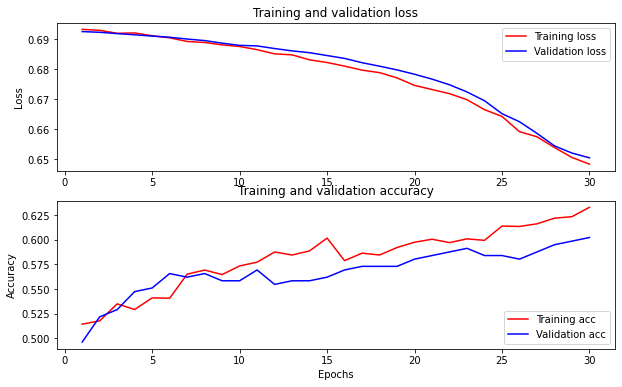

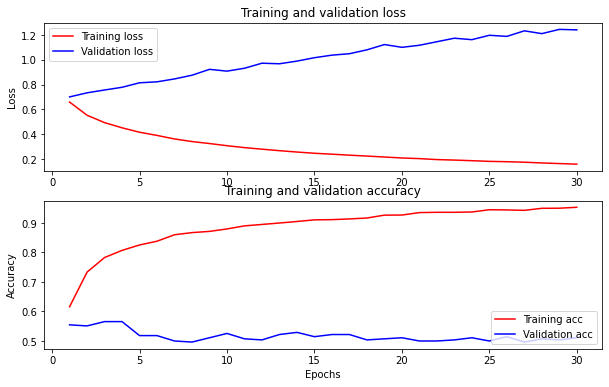

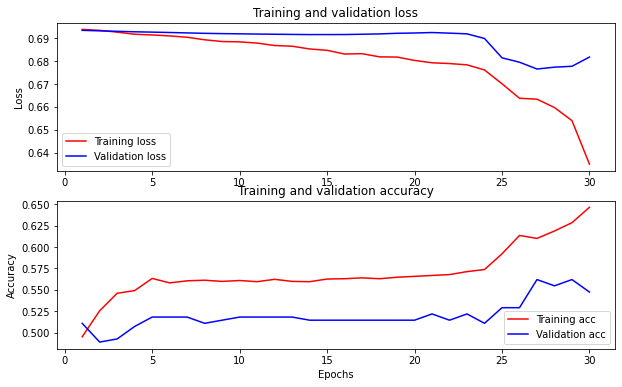

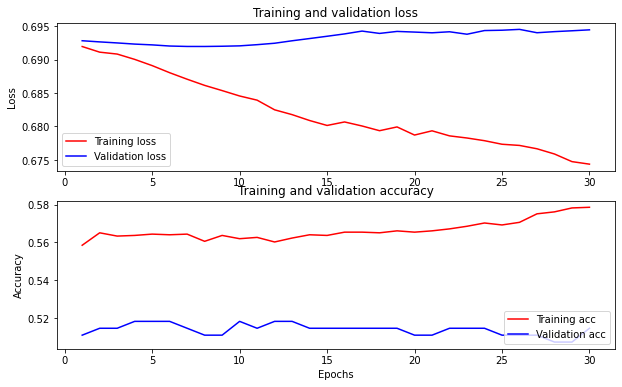

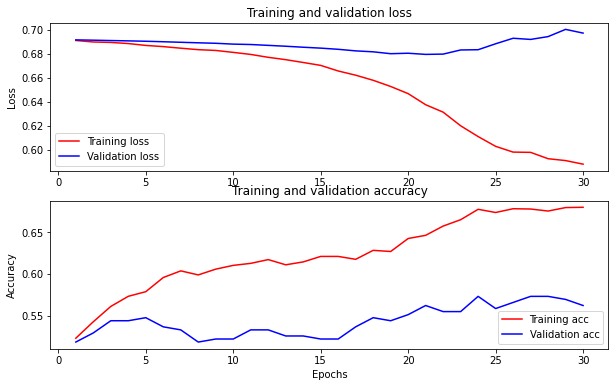

In [12]:
timesteps: list  = [90]
outputs: list  = [60, 90]
models: list = ['cnn', 'lstm', 'stacked_lstm', 'bilstm']
def run_timestep():
    # override for now
    for timestep in timesteps:
         for output in outputs:
            X_TRAIN_DIR, X_VAL_DIR, X_TEST_DIR, Y_TRAIN_DIR, Y_VAL_DIR, Y_TEST_DIR, EMBEDDING_MATRIX_DIR, VOCAB_DIR, TRAIN_CORPORA_DIR = load_directories(timestep, output)
            x_train, y_train, x_val, y_val, x_test, y_test, embedding_matrix, embedding_layer =  load_variables(X_TRAIN_DIR = X_TRAIN_DIR, X_VAL_DIR = X_VAL_DIR, X_TEST_DIR = X_TEST_DIR, Y_TRAIN_DIR = Y_TRAIN_DIR, Y_VAL_DIR = Y_VAL_DIR, Y_TEST_DIR = Y_TEST_DIR, EMBEDDING_DIR = EMBEDDING_MATRIX_DIR,)
            x_train,y_train = balance_training_dataset(x_train, y_train)
            x_train= tensorflow.convert_to_tensor(x_train)
            y_train= tensorflow.convert_to_tensor(y_train)
            file_suffix: str = f'_i{timestep}_o{output}'
            for model in models:
                accuracy, loss = run_model(model_type=model, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, x_test = x_test, y_test = y_test, embedding_layer= embedding_layer, file_suffix = file_suffix, timestep = timestep)
                print(f'Evaluation for {model} with {timestep} timesteps and {output} outputs')
                print(f'Loss: {loss}')
                print(f'Accuracy: {accuracy}')
run_timestep()